# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
#from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [5]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [6]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 1636/1636 [08:45<00:00,  3.11it/s]


In [7]:
dataframes[30]

('data/all_nano_structures_single_domain/6rbb.pdb',
              X          Y       Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     0.694000  -4.277000   5.308  174.20274           3.721274   
 1    -2.990000  -4.576000   5.740   75.06714           4.198928   
 2    -6.508000  -3.784000   4.701  105.09344           3.805953   
 3    -8.875000  -3.795000   7.749  147.13074           3.833386   
 4    -6.175000  -5.348000   9.939  165.19184           3.788165   
 ..         ...        ...     ...        ...                ...   
 478 -33.832001 -20.900999  10.996  117.14784           4.169421   
 479 -33.150002 -18.483999   8.138  119.12034           4.082392   
 480 -34.498001 -14.935000   8.444  117.14784           4.093996   
 481 -34.692001 -12.858000   5.268  105.09344           4.145524   
 482 -34.766998  -9.058000   5.304  105.09344           3.800911   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3.721274               1                      1  


In [8]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [9]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    # Optionally include coordinates in node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):  # Skip self-loop (j=0)
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )
    return data


In [10]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1636 [00:00<?]

# Graph representation vs reality

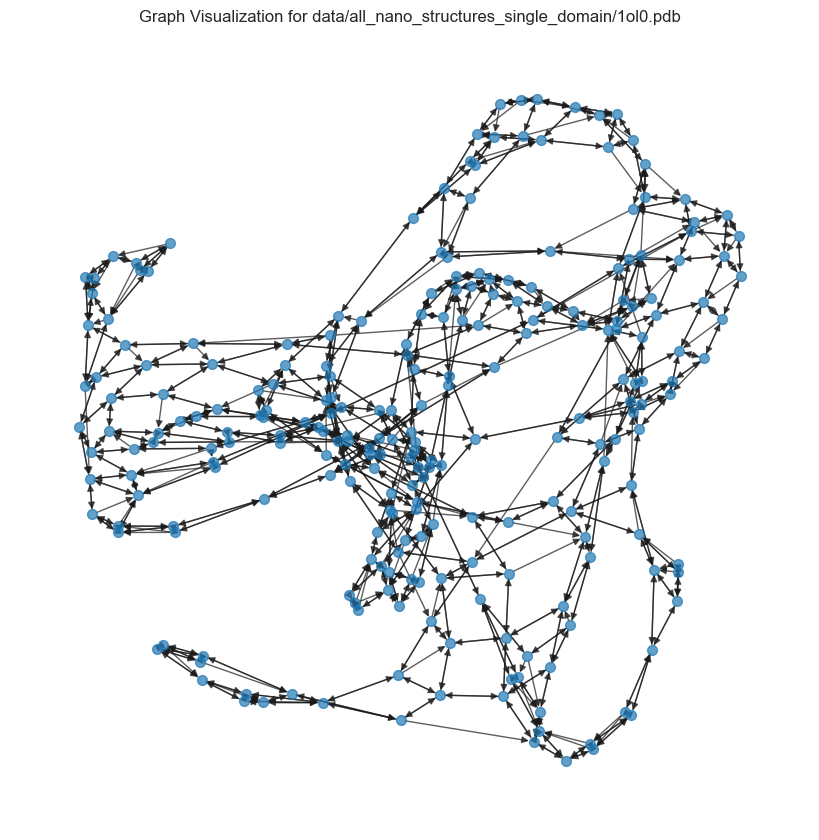

In [11]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph(data, pdb_file)


In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Define amino acid masses and their corresponding colors
AMINO_ACID_DATA = [
    (89.09404, "Alanine", "blue"),
    (121.15404, "Cysteine", "green"),
    (133.10384, "Aspartic acid", "red"),
    (147.13074, "Glutamic acid", "cyan"),
    (165.19184, "Phenylalanine", "magenta"),
    (75.06714, "Glycine", "yellow"),
    (155.15634, "Histidine", "orange"),
    (131.17464, "Isoleucine/Leucine", "purple"),
    (146.18934, "Lysine", "brown"),
    (149.20784, "Methionine", "pink"),
    (132.11904, "Asparagine", "lime"),
    (255.31000, "Pyrrolysine", "gold"),
    (115.13194, "Proline", "silver"),
    (146.14594, "Glutamine", "teal"),
    (174.20274, "Arginine", "coral"),
    (105.09344, "Serine", "navy"),
    (119.12034, "Threonine", "olive"),
    (168.05300, "Selenocysteine", "maroon"),
    (117.14784, "Valine", "black"),
    (204.22844, "Tryptophan", "violet"),
    (181.19124, "Tyrosine", "gray"),
]

# Convert amino acid data to lookup tables
MASS_TO_COLOR = {mass: color for mass, _, color in AMINO_ACID_DATA}
MASS_TO_NAME = {mass: name for mass, name, _ in AMINO_ACID_DATA}

def map_mass_to_color(mass):
    """Find the closest amino acid mass and return its color."""
    closest_mass = min(MASS_TO_COLOR.keys(), key=lambda m: abs(m - mass))
    return MASS_TO_COLOR[closest_mass]

def visualize_nanobody_graph_aminoacids(data, pdb_file):
    """
    Visualize a nanobody graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object.
    - pdb_file: Name of the nanobody structure file.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
        map_mass_to_color(node[1]['x'][0]) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [max(10, node[1]['x'][3] * 50) for node in G.nodes(data=True)]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [max(0.1, edge[2]['edge_attr'][0]) for edge in G.edges(data=True)]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(f"Graph Visualization for {pdb_file}", fontsize=14)
    plt.show()


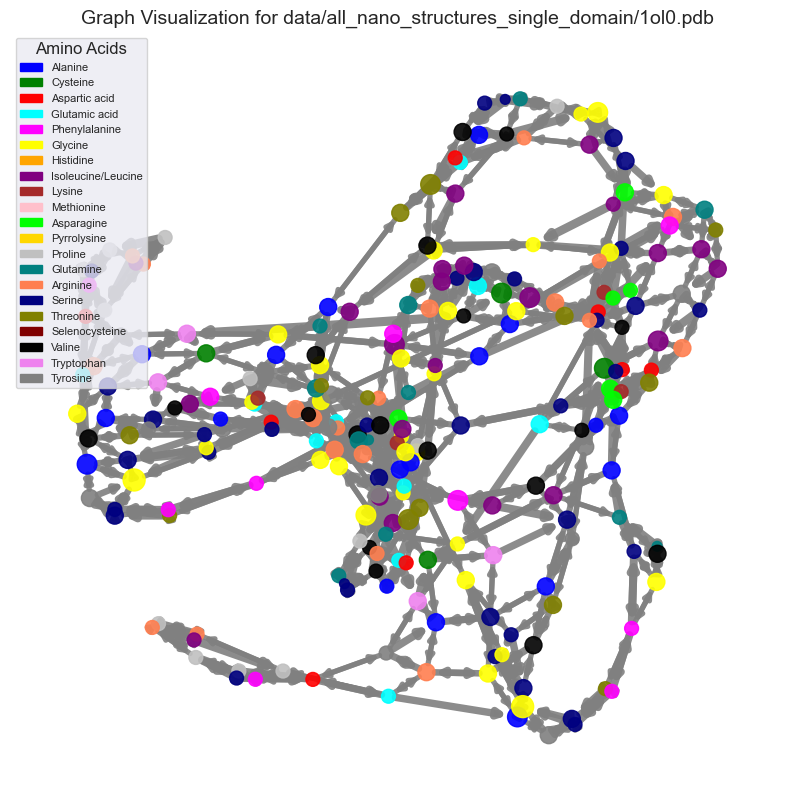

In [14]:
# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph_aminoacids(data, pdb_file)

In [14]:
# from IPython.display import display
# from PIL import Image
# import matplotlib.pyplot as plt

# # Paths to your images
# image_path_1 = "data/mab_dataset/3sn6.png"
# image_path_2 = "data/mab_dataset/3sn6_plot.png"

# # Open the images using PIL
# image_1 = Image.open(image_path_1)
# image_2 = Image.open(image_path_2)

# # Create a matplotlib figure
# fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

# # Display the first image
# axes[0].imshow(image_1)
# axes[0].axis('off')  # Hide axes
# axes[0].set_title("Image 1: Original")

# # Display the second image
# axes[1].imshow(image_2)
# axes[1].axis('off')  # Hide axes
# axes[1].set_title("Image 2: Plot")

# # Show the images
# plt.tight_layout()
# plt.show()


# Dataloader

In [15]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

def split_and_batch_graphs(graphs, batch_size=8, train_ratio=0.8, seed=42):
    """
    Split the graphs into train and test datasets, and create DataLoaders for batching.

    Parameters:
    - graphs (list): List of `torch_geometric.data.Data` graphs.
    - batch_size (int): Batch size for the DataLoader.
    - train_ratio (float): Proportion of data to use for training.
    - seed (int): Random seed for reproducibility.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - test_loader (DataLoader): DataLoader for the testing set.
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Split into train and test sets
    train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
    # Create DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [16]:
# Unpack graphs
graph_data = [graph for _, graph in graphs]  # Extract only the `Data` objects

# Split and batch the graphs
train_loader, test_loader = split_and_batch_graphs(graph_data, batch_size=16, train_ratio=0.8, seed=42)

# Optional: Keep file names for reference
pdb_files = [pdb_file for pdb_file, _ in graphs]

# Example: Iterate through training batches
for batch in train_loader:
    print(batch)  # This should now work as expected


DataBatch(x=[19018, 8], edge_index=[2, 76072], edge_attr=[76072, 1], batch=[19018], ptr=[17])
DataBatch(x=[14730, 8], edge_index=[2, 58920], edge_attr=[58920, 1], batch=[14730], ptr=[17])
DataBatch(x=[13917, 8], edge_index=[2, 55668], edge_attr=[55668, 1], batch=[13917], ptr=[17])
DataBatch(x=[33750, 8], edge_index=[2, 135000], edge_attr=[135000, 1], batch=[33750], ptr=[17])
DataBatch(x=[18678, 8], edge_index=[2, 74712], edge_attr=[74712, 1], batch=[18678], ptr=[17])
DataBatch(x=[18730, 8], edge_index=[2, 74920], edge_attr=[74920, 1], batch=[18730], ptr=[17])
DataBatch(x=[16440, 8], edge_index=[2, 65760], edge_attr=[65760, 1], batch=[16440], ptr=[17])
DataBatch(x=[18273, 8], edge_index=[2, 73092], edge_attr=[73092, 1], batch=[18273], ptr=[17])
DataBatch(x=[16023, 8], edge_index=[2, 64092], edge_attr=[64092, 1], batch=[16023], ptr=[17])
DataBatch(x=[19251, 8], edge_index=[2, 77004], edge_attr=[77004, 1], batch=[19251], ptr=[17])
DataBatch(x=[18347, 8], edge_index=[2, 73388], edge_attr=[

# GTA VAE - ALex

In [26]:
class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=32, num_heads=4, edge_dim=1):
        super().__init__()

        # Model parameters
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.latent_channels = latent_channels
        self.edge_dim = edge_dim

        # Feature indices
        self.mass_index = 0
        self.distance_indices = slice(1, 3)
        self.count_index = 3
        self.small_mol_index = 4
        self.coord_indices = slice(5, 8)

        # Loss weights
        self.loss_weights = {
            'mass': 0.01,
            'distance': 0.01,
            'count': 0.01,
            'small_mol': 0.01,
            'coord': 0.01,
            'edge': 0.01
        }

        # Encoder
        self.encoder_conv1 = torch.nn.ModuleList([
            GATConv(
                in_channels,
                hidden_channels,
                heads=num_heads,
                edge_dim=edge_dim,
                concat=True
            )
        ])

        self.encoder_conv2 = torch.nn.ModuleList([
            GATConv(
                hidden_channels * num_heads,
                hidden_channels,
                edge_dim=edge_dim,
                concat=False
            )
        ])

        self.encoder_ff = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_channels, latent_channels)
        self.fc_logvar = nn.Linear(hidden_channels, latent_channels)

        # Decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels + 1, hidden_channels * 2),  # +1 for position encoding
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Feature-specific heads
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3),
            nn.Tanh()
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2),
            nn.Softplus()
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

        self.edge_decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, edge_dim),
            nn.Softplus()
        )

    def encode(self, x, edge_index, edge_attr, batch):
        # Graph convolutions
        for conv in self.encoder_conv1:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        for conv in self.encoder_conv2:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        x = self.encoder_ff(x)
        x = global_mean_pool(x, batch)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, node_counts):
        batch_size = z.size(0)
        device = z.device

        #print(f"\nDecode started:")
        #print(f"Latent z shape: {z.shape}")
        #print(f"Node counts: {node_counts.tolist()}")

        all_features = []
        all_edge_index = []
        all_edge_attr = []
        node_offset = 0

        for i in range(batch_size):
            n_nodes = node_counts[i].item()
            #print(f"\nProcessing graph {i} with {n_nodes} nodes")

            # Create position embeddings
            pos_embedding = torch.linspace(0, 1, n_nodes, device=device).unsqueeze(1)

            # Repeat latent vector
            graph_z = z[i:i+1].repeat(n_nodes, 1)
            decoder_input = torch.cat([graph_z, pos_embedding], dim=1)

            # Generate features
            h = self.shared_decoder(decoder_input)

            # Generate node features
            coords = self.coord_head(h) * 10
            mass = self.mass_head(h)
            distances = self.distance_head(h)
            counts = self.count_head(h)
            small_mols = self.small_mol_head(h)

            # Combine features
            features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)
            all_features.append(features)

            # Generate edges based on coordinate proximity
            k = 10
            dist_matrix = torch.cdist(coords, coords)
            _, neighbor_indices = torch.topk(dist_matrix, k, dim=1, largest=False)

            # Create directed edges
            rows = torch.arange(n_nodes, device=device).unsqueeze(1).expand(-1, k)
            cols = neighbor_indices

            # Stack edges
            edges = torch.stack([rows.flatten(), cols.flatten()], dim=0)

            # Add offset for batch processing
            edges = edges + node_offset
            all_edge_index.append(edges)

            # Generate edge attributes
            edge_features = torch.cat([h[edges[0]], h[edges[1]]], dim=1)
            edge_attr = self.edge_decoder(edge_features)
            all_edge_attr.append(edge_attr)

            node_offset += n_nodes

        # Combine all features and edges
        features = torch.cat(all_features, dim=0)
        edge_index = torch.cat(all_edge_index, dim=1)
        edge_attr = torch.cat(all_edge_attr, dim=0)

        return features, edge_index, edge_attr

    def edge_loss_distribution(self, pred_attr, target_attr):
        # Compare distributions of edge attributes
        pred_mean = pred_attr.mean()
        target_mean = target_attr.mean()
        pred_std = pred_attr.std()
        target_std = target_attr.std()

        mean_loss = F.mse_loss(pred_mean.unsqueeze(0), target_mean.unsqueeze(0))
        std_loss = F.mse_loss(pred_std.unsqueeze(0), target_std.unsqueeze(0))

        return mean_loss + std_loss

    def feature_specific_loss(self, pred, target, edge_pred=None, edge_target=None):
        losses = {}
        EPS = 1e-6
    
        def safe_scale(x):
            scale = x.abs().mean() + EPS
            scale = torch.clamp(scale, min=EPS, max=1e6)
            return scale
    
        # Mass loss
        mass_pred = torch.clamp(pred[..., self.mass_index], min=-1e6, max=1e6)
        mass_target = target[..., self.mass_index]
        mass_scale = safe_scale(mass_target)
        losses['mass'] = F.mse_loss(mass_pred / mass_scale, mass_target / mass_scale) * self.loss_weights['mass']
    
        # Distance loss
        dist_pred = torch.clamp(pred[..., self.distance_indices], min=-1e6, max=1e6)
        dist_target = target[..., self.distance_indices]
        dist_scale = safe_scale(dist_target)
        losses['distance'] = F.mse_loss(dist_pred / dist_scale, dist_target / dist_scale) * self.loss_weights['distance']
    
        # Count loss
        count_pred = torch.clamp(pred[..., self.count_index], min=-1e6, max=1e6)
        count_target = target[..., self.count_index]
        count_scale = safe_scale(count_target)
        losses['count'] = F.mse_loss(count_pred / count_scale, count_target / count_scale) * self.loss_weights['count']
    
        # Small molecule loss - use sigmoid explicitly for numerical stability
        small_mol_pred = torch.clamp(pred[..., self.small_mol_index], min=-1e6, max=1e6)
        small_mol_target = target[..., self.small_mol_index]
        losses['small_mol'] = F.binary_cross_entropy_with_logits(
            small_mol_pred, small_mol_target.float()
        ) * self.loss_weights['small_mol']
    
        # Coordinate loss
        coord_pred = torch.clamp(pred[..., self.coord_indices], min=-1e6, max=1e6)
        coord_target = target[..., self.coord_indices]
        coord_scale = safe_scale(coord_target)
        losses['coord'] = F.mse_loss(coord_pred / coord_scale, coord_target / coord_scale) * self.loss_weights['coord']
    
        # Edge loss using distribution comparison
        if edge_pred is not None and edge_target is not None:
            edge_pred = torch.clamp(edge_pred, min=-1e6, max=1e6)
            losses['edge'] = self.edge_loss_distribution(edge_pred, edge_target) * self.loss_weights['edge']
    
        # Check for any NaN or Inf values
        for key, loss in losses.items():
            if not torch.isfinite(loss):
                print(f"Warning: {key} loss is not finite!")
                losses[key] = torch.tensor(0.0, device=loss.device)
    
        # Sum all finite losses
        total_loss = sum(loss for loss in losses.values() if torch.isfinite(loss))
    
        # Safety check on total loss
        if not torch.isfinite(total_loss):
            print("Warning: total loss is not finite! Setting to 0")
            total_loss = torch.tensor(0.0, device=total_loss.device)
    
        return total_loss, losses
    def forward(self, x, edge_index, edge_attr, batch):
        # Get number of nodes per graph
        unique, counts = torch.unique(batch, return_counts=True)

        # Encode
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        # Decode with actual node counts
        recon, new_edge_index, edge_recon = self.decode(z, counts)

        return recon, edge_recon, mu, logvar

In [27]:
def train_model(model, train_loader, test_loader, device, num_epochs=100, beta=0.001):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 0.1

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")

    history = {
        'train': {'total_loss': [], 'recon_loss': [], 'kl_loss': [],
                  'mass_loss': [], 'distance_loss': [], 'count_loss': [],
                  'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []},
        'test': {'total_loss': [], 'recon_loss': [], 'kl_loss': [],
                 'mass_loss': [], 'distance_loss': [], 'count_loss': [],
                 'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []}
    }

    from tqdm import tqdm
    import time

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Training phase
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                #print(f"Input edge count: {batch.edge_index.shape[1]}")
                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Calculate losses
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, batch.x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + beta * kl_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 100 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update losses
                batch_count += 1
                current_loss = loss.item()
                epoch_losses['total_loss'] += current_loss
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average training losses
        for k in epoch_losses:
            epoch_losses[k] = epoch_losses[k] / len(train_loader)
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                try:
                    batch = batch.to(device)

                    # Forward pass
                    recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                                batch.edge_attr, batch.batch)

                    # Calculate losses
                    recon_loss, feature_losses = model.feature_specific_loss(
                        recon_batch, batch.x, edge_recon, batch.edge_attr)

                    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = recon_loss + beta * kl_loss

                    # Update validation losses
                    test_losses['total_loss'] += loss.item()
                    test_losses['recon_loss'] += recon_loss.item()
                    test_losses['kl_loss'] += kl_loss.item()
                    for k, v in feature_losses.items():
                        test_losses[f'{k}_loss'] += v.item()

                except Exception as e:
                    print(f"\nError in validation batch:")
                    print(str(e))
                    continue

        # Average validation losses
        num_val_batches = len(test_loader)
        for k in test_losses:
            test_losses[k] /= num_val_batches
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print('Training:')
        print(f'Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}')
        print('Validation:')
        print(f'Total: {test_losses["total_loss"]:.4f}, '
              f'Recon: {test_losses["recon_loss"]:.4f}, '
              f'KL: {test_losses["kl_loss"]:.4f}')
        print('Feature Losses (Train/Val):')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f} / {test_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0 and hasattr(plt, 'figure'):
            plt.figure(figsize=(20, 10))

            # Plot 1: Total, Reconstruction, and KL losses
            plt.subplot(2, 2, 1)
            plt.plot(history['train']['total_loss'], label='Train Total')
            plt.plot(history['test']['total_loss'], label='Val Total')
            plt.plot(history['train']['recon_loss'], label='Train Recon')
            plt.plot(history['test']['recon_loss'], label='Val Recon')
            plt.plot(history['train']['kl_loss'], label='Train KL')
            plt.plot(history['test']['kl_loss'], label='Val KL')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training vs Validation Losses')
            plt.legend()
            plt.grid(True)

            # Plot 2: Feature-specific training losses
            plt.subplot(2, 2, 2)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                plt.plot(history['train'][k], label=f'Train {k}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Feature-specific Training Losses')
            plt.legend()
            plt.grid(True)

            # Plot 3: Feature-specific validation losses
            plt.subplot(2, 2, 3)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                plt.plot(history['test'][k], label=f'Val {k}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Feature-specific Validation Losses')
            plt.legend()
            plt.grid(True)

            # Plot 4: Log scale comparison
            plt.subplot(2, 2, 4)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                train_values = [max(1e-10, abs(x)) for x in history['train'][k]]
                val_values = [max(1e-10, abs(x)) for x in history['test'][k]]
                plt.semilogy(train_values, '--', label=f'Train {k}')
                plt.semilogy(val_values, label=f'Val {k}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (log scale)')
            plt.title('Feature-specific Losses (Log Scale)')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    print("\nTraining completed!")
    return model, history

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)
    feature_means = all_features.mean(dim=0)
    feature_stds = all_features.std(dim=0)

    # Prevent division by zero
    feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)

    # Normalize all graphs
    for graph in graphs:
        graph.x = (graph.x - feature_means) / feature_stds

        # Also normalize edge attributes (distances)
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = graph.edge_attr.std()
            if edge_std > 0:
                graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Rest of your existing function...
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Feature means:", feature_means)
    print(f"Feature stds:", feature_stds)

    # Return normalization parameters for later use (e.g., inference)
    return train_loader, test_loader, in_channels, (feature_means, feature_stds)

def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)



In [30]:
def generate_protein(model, n_nodes=500, device='cpu', feature_stats=None):
    """
    Generate a new protein structure from random latent vector
    
    Args:
        model: Trained ProteinGraphVAE model
        n_nodes: Number of nodes to generate
        device: torch device
        feature_stats: Tuple of (means, stds) used during training for normalization
    """
    model.eval()
    z = torch.randn(1, model.latent_channels, device=device)
    node_counts = torch.tensor([n_nodes], device=device)

    with torch.no_grad():
        node_features, edge_index, edge_attr = model.decode(z, node_counts)

        # Denormalize if stats provided
        if feature_stats is not None:
            means, stds = feature_stats
            node_features = node_features * stds + means

    return node_features, edge_index, edge_attr

def plot_protein_structure(node_features, edge_index, title="Generated Protein Structure"):
    """
    Plot 3D protein structure
    """
    import plotly.graph_objects as go
    import numpy as np

    # Extract coordinates
    coords = node_features[:, 5:8].cpu().numpy()  # Assuming coords are in last 3 columns

    # Create edges for visualization
    edges_x = []
    edges_y = []
    edges_z = []

    edge_index_np = edge_index.cpu().numpy()

    # Add edges to plot
    for i in range(edge_index_np.shape[1]):
        start_idx = edge_index_np[0, i]
        end_idx = edge_index_np[1, i]

        edges_x.extend([coords[start_idx, 0], coords[end_idx, 0], None])
        edges_y.extend([coords[start_idx, 1], coords[end_idx, 1], None])
        edges_z.extend([coords[start_idx, 2], coords[end_idx, 2], None])

    # Create the 3D plot
    fig = go.Figure(data=[
        # Plot nodes
        go.Scatter3d(
            x=coords[:, 0],
            y=coords[:, 1],
            z=coords[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=node_features[:, 0].cpu(),  # Color by mass
                colorscale='Viridis',
                colorbar=dict(title="Mass"),
            ),
            text=[f"Node {i}<br>Mass: {m:.2f}" for i, m in enumerate(node_features[:, 0].cpu())],
            hoverinfo='text',
            name='Nodes'
        ),
        # Plot edges
        go.Scatter3d(
            x=edges_x,
            y=edges_y,
            z=edges_z,
            mode='lines',
            line=dict(color='gray', width=1),
            hoverinfo='none',
            name='Edges'
        )
    ])

    # Update layout
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        showlegend=True,
        width=800,
        height=800
    )

    fig.show()

def print_node_statistics(node_features):
    """
    Print statistics about the generated nodes
    """
    print("\nNode Feature Statistics:")
    print(f"Number of nodes: {node_features.shape[0]}")

    # Print statistics for each feature
    feature_names = ['Mass', 'Avg Neighbor Dist', 'Max Neighbor Dist',
                     'Neighbor Count', 'Small Molecules', 'X', 'Y', 'Z']

    for i, name in enumerate(feature_names):
        if i == 1:  # Distance features are 2D
            values = node_features[:, 1:3]
            mean = values.mean(dim=0)
            std = values.std(dim=0)
            print(f"\n{name}:")
            print(f"Mean: {mean.tolist()}")
            print(f"Std: {std.tolist()}")
        elif i < 5:  # Other scalar features
            values = node_features[:, i]
            print(f"\n{name}:")
            print(f"Mean: {values.mean():.3f}")
            print(f"Std: {values.std():.3f}")
            print(f"Min: {values.min():.3f}")
            print(f"Max: {values.max():.3f}")

    # Print coordinate statistics
    coords = node_features[:, 5:8]
    print("\nCoordinate Statistics:")
    print(f"Center of mass: {coords.mean(dim=0).tolist()}")
    print(f"Spatial extent: {coords.std(dim=0).tolist()}")

# Usage example:
def generate_and_visualize_protein(model, n_nodes=500, device='cpu'):
    """
    Generate and visualize a new protein structure
    """
    # Generate protein
    node_features, edge_index, edge_attr = generate_protein(model, n_nodes, device)

    # Print statistics
    print_node_statistics(node_features)

    # Plot structure
    plot_protein_structure(node_features, edge_index)

    return node_features, edge_index, edge_attr

In [31]:
def print_node_statistics(node_features):
    """
    Print statistics about the generated nodes
    """
    print("\nNode Feature Statistics:")
    print(f"Number of nodes: {node_features.shape[0]}")

    # Print statistics for each feature
    feature_names = ['Mass', 'Avg Neighbor Dist', 'Max Neighbor Dist',
                     'Neighbor Count', 'Small Molecules', 'X', 'Y', 'Z']

    print("\nOverall Statistics:")
    for i, name in enumerate(feature_names):
        if i == 1:  # Distance features are 2D
            values = node_features[:, 1:3]
            mean = values.mean(dim=0)
            std = values.std(dim=0)
            print(f"\n{name}:")
            print(f"Mean: {mean.tolist()}")
            print(f"Std: {std.tolist()}")
        elif i < 5:  # Other scalar features
            values = node_features[:, i]
            print(f"\n{name}:")
            print(f"Mean: {values.mean():.3f}")
            print(f"Std: {values.std():.3f}")
            print(f"Min: {values.min():.3f}")
            print(f"Max: {values.max():.3f}")

    # Print coordinate statistics
    coords = node_features[:, 5:8]
    print("\nCoordinate Statistics:")
    print(f"Center of mass: {coords.mean(dim=0).tolist()}")
    print(f"Spatial extent: {coords.std(dim=0).tolist()}")

    # Print detailed information for first 10 nodes
    print("\nDetailed First 10 Nodes:")
    print("Node |    Mass    | Avg Dist  | Max Dist  | Count | Small Mol |     X     |     Y     |     Z     |")
    print("-" * 90)

    num_nodes_to_print = min(10, node_features.shape[0])
    for i in range(num_nodes_to_print):
        node = node_features[i]
        print(f"{i:4d} | {node[0]:9.3f} | {node[1]:8.3f} | {node[2]:8.3f} | {node[3]:5.1f} | {node[4]:8.3f} | {node[5]:8.3f} | {node[6]:8.3f} | {node[7]:8.3f} |")

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def plot_latent_space(model, data_loader, device, method='pca'):
    """
    Plot the latent space of the model using PCA or t-SNE.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
        method: Dimensionality reduction method ('pca' or 'tsne').

    Returns:
        None
    """
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(batch.batch.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_latent = reducer.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=labels[:reduced_latent.shape[0]], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Batch')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [39]:
# Take only first 10 graphs
graphs_subset = graphs[:100]

# The function returns train_loader, test_loader, in_channels, and normalization parameters
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs_subset,
    batch_size=1,
    train_ratio=0.8,
    shuffle=True
)

model = ProteinGraphVAE(
    in_channels=in_channels,
    hidden_channels=64,
    latent_channels=32
).to(device)



Dataset prepared:
Number of training graphs: 80
Number of test graphs: 20
Number of features per node: 8
Feature means: tensor([-2.6942e-09, -9.8550e-09,  8.5079e-10,  2.9866e-08, -1.4333e-08,
         3.1993e-09, -5.1180e-09,  8.2420e-10])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



# Generation pre training

In [40]:
# Assuming you have a trained model
model = model.to(device)

# Generate and visualize a protein
node_features, edge_index, edge_attr = generate_and_visualize_protein(
    model,
    n_nodes=500,  # Adjust this number as needed
    device=device
)
print_node_statistics(node_features)


Node Feature Statistics:
Number of nodes: 500

Overall Statistics:

Mass:
Mean: 0.694
Std: 0.000
Min: 0.693
Max: 0.694

Avg Neighbor Dist:
Mean: [0.7176971435546875, 0.7324402332305908]
Std: [0.0007312301313504577, 0.00031356833642348647]

Max Neighbor Dist:
Mean: 0.732
Std: 0.000
Min: 0.732
Max: 0.733

Neighbor Count:
Mean: 0.726
Std: 0.001
Min: 0.725
Max: 0.727

Small Molecules:
Mean: -0.041
Std: 0.001
Min: -0.042
Max: -0.040

Coordinate Statistics:
Center of mass: [-0.7607998847961426, 0.11793509125709534, -0.5482399463653564]
Spatial extent: [0.0194714218378067, 0.013851147145032883, 0.001965993084013462]

Detailed First 10 Nodes:
Node |    Mass    | Avg Dist  | Max Dist  | Count | Small Mol |     X     |     Y     |     Z     |
------------------------------------------------------------------------------------------
   0 |     0.694 |    0.717 |    0.733 |   0.7 |   -0.040 |   -0.794 |    0.144 |   -0.554 |
   1 |     0.694 |    0.717 |    0.733 |   0.7 |   -0.040 |   -0.794 |  


Node Feature Statistics:
Number of nodes: 500

Overall Statistics:

Mass:
Mean: 0.694
Std: 0.000
Min: 0.693
Max: 0.694

Avg Neighbor Dist:
Mean: [0.7176971435546875, 0.7324402332305908]
Std: [0.0007312301313504577, 0.00031356833642348647]

Max Neighbor Dist:
Mean: 0.732
Std: 0.000
Min: 0.732
Max: 0.733

Neighbor Count:
Mean: 0.726
Std: 0.001
Min: 0.725
Max: 0.727

Small Molecules:
Mean: -0.041
Std: 0.001
Min: -0.042
Max: -0.040

Coordinate Statistics:
Center of mass: [-0.7607998847961426, 0.11793509125709534, -0.5482399463653564]
Spatial extent: [0.0194714218378067, 0.013851147145032883, 0.001965993084013462]

Detailed First 10 Nodes:
Node |    Mass    | Avg Dist  | Max Dist  | Count | Small Mol |     X     |     Y     |     Z     |
------------------------------------------------------------------------------------------
   0 |     0.694 |    0.717 |    0.733 |   0.7 |   -0.040 |   -0.794 |    0.144 |   -0.554 |
   1 |     0.694 |    0.717 |    0.733 |   0.7 |   -0.040 |   -0.794 |  

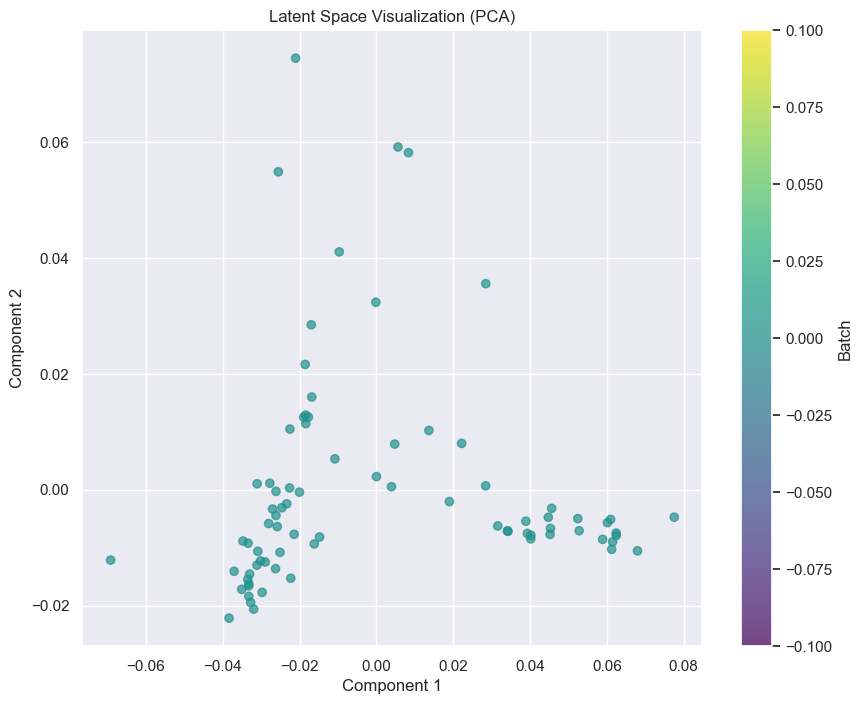

In [41]:
# Assuming `train_loader` is your DataLoader and `model` is your ProteinGraphVAE instance
plot_latent_space(model, train_loader, device, method='pca')

In [42]:
def sample_and_decode(model, num_samples=5, device='cpu'):
    """
    Sample random latent vectors and decode them to check for diversity in outputs.

    Args:
        model: Trained ProteinGraphVAE model.
        num_samples: Number of samples to generate.
        device: torch device.

    Returns:
        List of decoded node features.
    """
    model.eval()
    decoded_samples = []

    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, model.latent_channels, device=device)
            node_counts = torch.tensor([500], device=device)  # Adjust node count as needed
            node_features, edge_index, edge_attr = model.decode(z, node_counts)
            decoded_samples.append(node_features.cpu().numpy())

    return decoded_samples

# Example usage
decoded_samples = sample_and_decode(model, num_samples=5, device=device)
for i, sample in enumerate(decoded_samples):
    print(f"Sample {i+1}:")
    print(sample)

Sample 1:
[[ 0.6904935   0.7000668   0.7323573  ... -0.8936513   0.25222516
  -0.6793028 ]
 [ 0.6904918   0.7000692   0.7323605  ... -0.89353913  0.25230396
  -0.67924094]
 [ 0.6904901   0.7000716   0.73236364 ... -0.8934266   0.25238287
  -0.67917913]
 ...
 [ 0.69003636  0.70195174  0.73343945 ... -0.8286733   0.29042664
  -0.6238346 ]
 [ 0.69003683  0.70195687  0.7334406  ... -0.82855487  0.2904719
  -0.6236788 ]
 [ 0.69003725  0.70196193  0.73344165 ... -0.8284363   0.2905174
  -0.6235231 ]]
Sample 2:
[[ 0.6897752   0.7128891   0.718255   ... -1.0821414   0.2196125
  -0.62276   ]
 [ 0.6897703   0.7128887   0.71825635 ... -1.0821208   0.21983954
  -0.6228041 ]
 [ 0.6897654   0.7128883   0.71825767 ... -1.0820999   0.22006668
  -0.62284786]
 ...
 [ 0.6877742   0.71157694  0.7186115  ... -1.0648305   0.31693116
  -0.64926946]
 [ 0.6877715   0.7115739   0.71861094 ... -1.0647435   0.31713456
  -0.64935136]
 [ 0.6877688   0.7115709   0.71861047 ... -1.0646565   0.31733778
  -0.6494334 ]]

In [ ]:
# Train with adjusted parameters
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=100,
    beta=0.01
)

In [77]:
# Assuming you have a trained model
model = model.to(device)

# Generate and visualize a protein
node_features, edge_index, edge_attr = generate_and_visualize_protein(
    model,
    n_nodes=500,  # Adjust this number as needed
    device=device
)
print_node_statistics(node_features)


Decode started:
Latent z shape: torch.Size([1, 32])
Node counts: [500]

Processing graph 0 with 500 nodes

Node Feature Statistics:
Number of nodes: 500

Overall Statistics:

Mass:
Mean: 0.002
Std: 0.000
Min: 0.001
Max: 0.002

Avg Neighbor Dist:
Mean: [0.0028318208642303944, 0.003182469867169857]
Std: [6.747170118615031e-05, 7.889690459705889e-05]

Max Neighbor Dist:
Mean: 0.003
Std: 0.000
Min: 0.003
Max: 0.003

Neighbor Count:
Mean: 0.015
Std: 0.000
Min: 0.015
Max: 0.016

Small Molecules:
Mean: -3.116
Std: 0.003
Min: -3.120
Max: -3.113

Coordinate Statistics:
Center of mass: [-0.265829473733902, -0.32336169481277466, -0.7152017951011658]
Spatial extent: [0.0004991848254576325, 0.008878865279257298, 0.007490425370633602]

Detailed First 10 Nodes:
Node |    Mass    | Avg Dist  | Max Dist  | Count | Small Mol |     X     |     Y     |     Z     |
------------------------------------------------------------------------------------------
   0 |     0.002 |    0.003 |    0.003 |   0.0 |   


Node Feature Statistics:
Number of nodes: 500

Overall Statistics:

Mass:
Mean: 0.002
Std: 0.000
Min: 0.001
Max: 0.002

Avg Neighbor Dist:
Mean: [0.0028318208642303944, 0.003182469867169857]
Std: [6.747170118615031e-05, 7.889690459705889e-05]

Max Neighbor Dist:
Mean: 0.003
Std: 0.000
Min: 0.003
Max: 0.003

Neighbor Count:
Mean: 0.015
Std: 0.000
Min: 0.015
Max: 0.016

Small Molecules:
Mean: -3.116
Std: 0.003
Min: -3.120
Max: -3.113

Coordinate Statistics:
Center of mass: [-0.265829473733902, -0.32336169481277466, -0.7152017951011658]
Spatial extent: [0.0004991848254576325, 0.008878865279257298, 0.007490425370633602]

Detailed First 10 Nodes:
Node |    Mass    | Avg Dist  | Max Dist  | Count | Small Mol |     X     |     Y     |     Z     |
------------------------------------------------------------------------------------------
   0 |     0.002 |    0.003 |    0.003 |   0.0 |   -3.115 |   -0.266 |   -0.339 |   -0.704 |
   1 |     0.002 |    0.003 |    0.003 |   0.0 |   -3.115 |   -0.